<a href="https://colab.research.google.com/github/Mangostudent/sideinfo/blob/main/sideinfo_debugging.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


Mean Accuracies across all runs:
Logistic Regression - Full Info: 0.7493 (±0.0137)
Logistic Regression - No Info: 0.6378 (±0.0115)
Logistic Regression - Side Info: 0.8236 (±0.0152)
Logistic Regression - Side Minus No Info: 0.7179 (±0.0681)
SVM - Full Info: 0.8471 (±0.0111)
SVM - No Info: 0.6407 (±0.0098)
SVM - Side Info: 0.8376 (±0.0189)
SVM - Side Minus No Info: 0.8360 (±0.0167)
KNN - Full Info: 0.7813 (±0.0144)
KNN - No Info: 0.5479 (±0.0143)
KNN - Side Info: 0.5932 (±0.0262)
KNN - Side Minus No Info: 0.7842 (±0.0252)


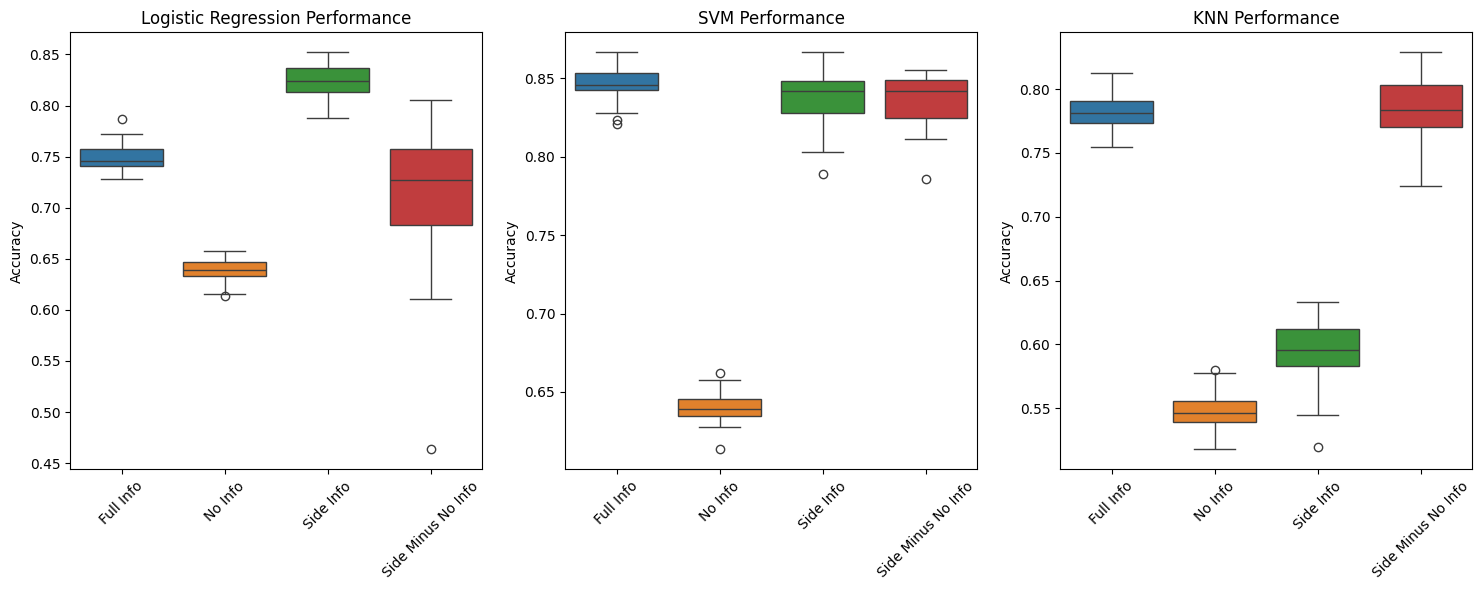

In [4]:
import numpy as np
import random
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Previous TrivariateRV class and train_and_evaluate_models function remain the same
class TrivariateRV:
    def __init__(self, joint_dist):
        self.joint_dist = joint_dist
        self.keys = list(joint_dist.keys())
        self.probs = [joint_dist[key][0] for key in self.keys]

    def generate_data(self, num_samples):
        data = []
        for _ in range(num_samples):
            y, z = random.choices(self.keys, weights=self.probs, k=1)[0]
            x = self.joint_dist[(y, z)][1]()
            data.append([x, y, z])
        return np.array(data)

def train_and_evaluate_models(train_1, train_2, test_data, classifier_class, **classifier_params):
    # Model 1: Full Info
    training_data = np.concatenate((train_1, train_2), axis=0)
    model1 = classifier_class(**classifier_params)
    model1.fit(training_data[:, [0, 2]], training_data[:, 1])

    # Model 2: No Info
    model2 = classifier_class(**classifier_params)
    model2.fit(training_data[:, [0]].reshape(-1, 1), training_data[:, 1])

    # Model 3: Side Info
    model3_1 = classifier_class(**classifier_params)
    model3_1.fit(train_1[:, [0]], train_1[:, 1])

    predictions = model3_1.predict(train_2[:, [0]])
    comparison = np.where(predictions == train_2[:, 1], 1, -1)

    model3_2 = classifier_class(**classifier_params)
    model3_2.fit(train_2[:, [0, 2]], comparison)

    def combined_predict(X, Z):
        pred1 = model3_1.predict(X.reshape(-1, 1))
        pred2 = model3_2.predict(np.column_stack([X, Z]))
        return np.where(pred2 == 1, pred1, -pred1)

    # Model 4: Side Minus No Info
    model4 = classifier_class(**classifier_params)
    model4.fit(train_2[:, [0, 2]], train_2[:, 1])

    test_features = test_data[:, [0, 2]]
    test_labels = test_data[:, 1]

    accuracies = {
        "Full Info": accuracy_score(test_labels, model1.predict(test_features)),
        "No Info": accuracy_score(test_labels, model2.predict(test_data[:, [0]].reshape(-1, 1))),
        "Side Info": accuracy_score(test_labels, [combined_predict(x, z) for x, z in test_features]),
        "Side Minus No Info": accuracy_score(test_labels, model4.predict(test_features))
    }

    return accuracies

# Setup parameters
n_runs = 30  # Number of test runs
joint_dist = {
    (1, 1): (0.3, lambda: np.random.normal(0.01, 1)),
    (1, -1): (0.2, lambda: np.random.normal(2, 1)),
    (-1, 1): (0.4, lambda: np.random.normal(2.01, 1)),
    (-1, -1): (0.1, lambda: np.random.normal(0, 1))
}

classifiers = {
    'Logistic Regression': (LogisticRegression, {'max_iter': 1000}),
    'SVM': (SVC, {'kernel': 'rbf', 'random_state': 42}),
    'KNN': (KNeighborsClassifier, {'n_neighbors': 2})
}

# Initialize results storage
all_results = {name: [] for name in classifiers.keys()}

# Run multiple tests
for run in range(n_runs):
    np.random.seed(run)  # Different seed for each run

    trivariate_rv = TrivariateRV(joint_dist)
    train = 3000
    n = 2900
    m = train - n
    test_size = int(0.3 * train)

    train_1 = trivariate_rv.generate_data(n)
    train_2 = trivariate_rv.generate_data(m)
    test_data = trivariate_rv.generate_data(test_size)

    for clf_name, (classifier, params) in classifiers.items():
        accuracies = train_and_evaluate_models(train_1, train_2, test_data, classifier, **params)
        all_results[clf_name].append(accuracies)

# Convert results to DataFrame for easier analysis
results_df = pd.DataFrame({
    (clf_name, model_name): [run[model_name] for run in results]
    for clf_name, results in all_results.items()
    for model_name in results[0].keys()
})

# Calculate mean accuracies
mean_accuracies = results_df.mean()
std_accuracies = results_df.std()

print("\nMean Accuracies across all runs:")
print("================================")
for (clf_name, model_name), mean_acc in mean_accuracies.items():
    std_acc = std_accuracies[(clf_name, model_name)]
    print(f"{clf_name} - {model_name}: {mean_acc:.4f} (±{std_acc:.4f})")

# Create visualization
plt.figure(figsize=(15, 6))
for i, clf_name in enumerate(classifiers.keys()):
    plt.subplot(1, 3, i+1)
    data = results_df[clf_name]

    sns.boxplot(data=data)
    plt.title(f'{clf_name} Performance')
    plt.xticks(rotation=45)
    plt.ylabel('Accuracy')

plt.tight_layout()
plt.show()



In [8]:
# train = TrivariateRV(joint_dist).generate_data(3000)
# test = TrivariateRV(joint_dist).generate_data(1000)

# modelA  = SVC()
# modelA.fit(train[:, [0, 2]], train[:, 1])

# modelB1 = SVC()
# modelB1.fit(train[:, [0]].reshape(-1,1), train[:, 1])

# modelB1_predictions = modelB1.predict(train[:, [0]].reshape(-1,1))

# error_modelB1 = np.where(modelB1_predictions == train[:, 1], 1, -1)

# modelB2 = SVC()
# modelB2.fit(train[:, [0, 2]], error_modelB1)

# def modelB(x, z):
#     return np.where(modelB2.predict([[x, z]])[0] == 1, modelB1.predict([[x]])[0], -modelB1.predict([[x]])[0])

# yA = modelA.predict(test[:, [0, 2]])
# accuracyA = accuracy_score(test[:, 1], yA)
# print(f"Accuracy for Model A: {accuracyA}")
# yB = [modelB(x,z) for x,z in test[:, [0, 2]]]
# accuracyB = accuracy_score(test[:, 1], yB)
# print(f"Accuracy for Model B: {accuracyB}")


Accuracy for Model A: 0.843
Accuracy for Model B: 0.826
